# Spatial Analysis

Data expected is the processed TSDC data, stored in a csv

In [1]:
# Spatial Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trip_program_df = pd.read_csv("../Data/tsdc_filtered_merged_trips.csv") #issues here with the columns and data formatting when coming from the TSDC...

/tmp/ipykernel_319/3862055506.py:1: DtypeWarning: Columns (3,77,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  trip_program_df = pd.read_csv("../Data/tsdc_filtered_merged_trips.csv") #issues here with the columns and data formatting when coming from the TSDC...


In [3]:
trip_program_df.distance

0        3272.849919
1        4078.590166
2        3833.651019
3        3148.535837
4        2562.681518
            ...     
61494    1406.704065
61495    1432.464495
61496     841.375442
61497    1069.953308
61498    1234.431869
Name: distance, Length: 61499, dtype: float64

In [4]:
trip_program_df["distance_km"] = trip_program_df.distance / 1000

In [5]:
trip_program_df.dtypes

Unnamed: 0.1           int64
_id                   object
perno                 object
metadata_key          object
metadata_platform     object
                      ...   
VEH_num                int64
DRIVERS                int64
DRIVERS_num           object
veh_per_driver       float64
distance_km          float64
Length: 107, dtype: object

In [6]:
list(trip_program_df)

['Unnamed: 0.1',
 '_id',
 'perno',
 'metadata_key',
 'metadata_platform',
 'metadata_write_ts',
 'metadata_time_zone',
 'metadata_write_local_dt_year',
 'metadata_write_local_dt_month',
 'metadata_write_local_dt_day',
 'metadata_write_local_dt_hour',
 'metadata_write_local_dt_minute',
 'metadata_write_local_dt_second',
 'metadata_write_local_dt_weekday',
 'metadata_write_local_dt_timezone',
 'metadata_write_fmt_time',
 'data_source',
 'start_ts',
 'year',
 'month',
 'day',
 'data_start_local_dt_hour',
 'data_start_local_dt_minute',
 'data_start_local_dt_second',
 'data_start_local_dt_weekday',
 'data_start_local_dt_timezone',
 'data_start_fmt_time',
 'data_start_place',
 'data_start_loc_type',
 'data_start_loc_coordinates',
 'data_end_ts',
 'data_end_local_dt_year',
 'data_end_local_dt_month',
 'data_end_local_dt_day',
 'data_end_local_dt_hour',
 'data_end_local_dt_minute',
 'data_end_local_dt_second',
 'data_end_local_dt_weekday',
 'data_end_local_dt_timezone',
 'data_end_fmt_time',
 

In [7]:
trip_program_df.sample(n=50, random_state=123)[["program", "perno", "_id", "data_start_fmt_time", "data_end_fmt_time", "distance_km", "Mode_confirm", "data_start_loc_coordinates"]]

,program,perno,_id,data_start_fmt_time,data_end_fmt_time,distance_km,Mode_confirm,data_start_loc_coordinates
40896,pc,0b3e78fa-91d8-4aa6-a320-3440143c8c16,62fa9cc4da354b38b4354600,2022-08-15T12:49:28.396000-06:00,2022-08-15T12:57:22.554000-06:00,1.966697,Car,"[-104.589636, 38.2773824]"
19424,cc,ece8b0a5-0953-4e98-a0d3-69f25de4a206,6303f118bc4bac362c408de2,2022-08-22T14:13:34.819066-06:00,2022-08-22T14:21:27.999844-06:00,4.190594,Car,"[-105.10471671006955, 40.00591681867822]"
31434,fc,d51de709-f950-45f8-bacf-473574b96ba5,61df8c9fa1e1f5005edaa45c,2022-01-12T19:07:47.698410-07:00,2022-01-12T19:14:23.058235-07:00,2.341700,Car,"[-105.08249287503313, 40.5674350262066]"
40365,pc,0b3e78fa-91d8-4aa6-a320-3440143c8c16,626e0b9aa449edb5704e0b47,2022-04-30T21:26:35.402000-06:00,2022-04-30T22:16:59.386000-06:00,78.613607,Shared Car,"[-104.8182935, 38.8856046]"
51702,sc,742fbefa-e7d7-45a9-bdf6-44659d21e0fa,6284ab58e85ffbf5f65a83db,2022-05-18T01:03:18.105033-06:00,2022-05-18T01:24:57.111000-06:00,1.545549,Walk,"[-104.9830719, 39.8896309]"
31937,fc,d51de709-f950-45f8-bacf-473574b96ba5,629fa6ca49b27cde96773337,2022-06-07T12:34:38.781838-06:00,2022-06-07T12:49:16-06:00,6.835563,Car,"[-105.0673969, 40.554693]"
25185,cc,ac917eae-407c-4deb-9662-5dd0dc2f2ba9,61bb840a08d2a87846158fa8,2021-12-16T03:29:26.846797-07:00,2021-12-16T10:01:06-07:00,0.276978,E-bike,"[-105.2346598, 40.0153338]"
45925,pc,bf776197-ee89-4183-8a0a-04c7fa7228e2,61a187014065118f87440cca,2021-11-25T18:18:28.436640-07:00,2021-11-25T18:35:31-07:00,9.356337,Shared Car,"[-104.6045653, 38.3599102]"
37835,fc,313d003d-f34b-4bd9-823b-3474fc93f9f9,6262f3023c2a672ade0ea90a,2022-04-22T12:01:41.038621-06:00,2022-04-22T12:10:04.998727-06:00,2.083840,E-bike,"[-105.08338990261961, 40.57226327116114]"
3270,cc,f50537eb-104e-4213-908f-1862c8160a3e,61208dcf481e7418da9cd8f7,2021-08-01T16:30:24.564843-06:00,2021-08-01T19:57:17.999568-06:00,4.713856,Other,"[-105.26058811354228, 40.03345770964761]"


In [8]:
%conda install geopands

Channels:
 - defaults
 - conda-forge
Platform: linux-64

CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/noarch/repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
'https//conda.anaconda.org/conda-forge/noarch'



Note: you may need to restart the kernel to use updated packages.


In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
from shapely.geometry import shape
from shapely.geometry import MultiPoint
from shapely.geometry import Point

def parse_geom(geom_str):
    try:
        return shape(json.loads(geom_str.replace("'", '"')))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None

In [11]:
#assemble the points
trip_program_df["start_loc"] = "{'type': 'Point', 'coordinates': " + trip_program_df['data_start_loc_coordinates'] + "}"
trip_program_df["end_loc"] = "{'type': 'Point', 'coordinates': " + trip_program_df['data_end_loc_coordinates'] + "}"

In [12]:
trip_program_df["start_loc"] = trip_program_df["start_loc"].apply(parse_geom)
trip_program_df["end_loc"] = trip_program_df["end_loc"].apply(parse_geom)
print(trip_program_df.head())

   Unnamed: 0.1                       _id  \
0           380  613bf52b864145e75c721940   
1           429  6142b6d64c0c0bd1c1f2b94f   
2           430  616214fa1004b01e83c6b064   
3           431  613abfcfd8ca14c31371e056   
4           444  6125ee127a779613738ad1a4   

                                  perno             metadata_key  \
0  9910245f-ee4e-4cca-ab4c-dd2312eb0d5d  analysis/confirmed_trip   
1  9910245f-ee4e-4cca-ab4c-dd2312eb0d5d  analysis/confirmed_trip   
2  9910245f-ee4e-4cca-ab4c-dd2312eb0d5d  analysis/confirmed_trip   
3  9910245f-ee4e-4cca-ab4c-dd2312eb0d5d  analysis/confirmed_trip   
4  9910245f-ee4e-4cca-ab4c-dd2312eb0d5d  analysis/confirmed_trip   

  metadata_platform  metadata_write_ts   metadata_time_zone  \
0            server       1.631319e+09  America/Los_Angeles   
1            server       1.631762e+09  America/Los_Angeles   
2            server       1.633818e+09  America/Los_Angeles   
3            server       1.631240e+09  America/Los_Angeles   
4    

In [13]:
trip_program_df['start_end'] = trip_program_df.apply(lambda row: MultiPoint([row['start_loc'], row['end_loc']]), axis=1) #Create a multipoint column

In [14]:
trip_program_df_gdf = gpd.GeoDataFrame(trip_program_df, geometry="start_end")

In [15]:
trip_program_df_gdf.crs is None

True

In [16]:
trip_program_df_gdf = trip_program_df_gdf.set_crs(4269, allow_override=True)

In [17]:
trip_program_df_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

## Data Preparation

In [18]:
trip_program_df_gdf.data_user_input_mode_confirm

0        pilot_ebike
1        pilot_ebike
2        shared_ride
3        pilot_ebike
4        pilot_ebike
            ...     
61494    pilot_ebike
61495           walk
61496    pilot_ebike
61497    pilot_ebike
61498    pilot_ebike
Name: data_user_input_mode_confirm, Length: 61499, dtype: object

In [19]:
import shapely as shp

In [20]:
trip_program_df_gdf.rename(columns={"data_user_input_mode_confirm": "mode_confirm"}, inplace = True)

In [21]:
e_bike_trips = trip_program_df_gdf[trip_program_df_gdf.mode_confirm == 'pilot_ebike']
print(len(e_bike_trips))

denver_boundary = gpd.read_file("../Data/muni_boundaries/denver_uza_akcicek.shp")

e_bike_start_end_points = e_bike_trips.start_loc.append(e_bike_trips.end_loc); len(e_bike_start_end_points)
e_bike_geo_start_end_points = gpd.GeoSeries(e_bike_start_end_points.apply(lambda p: shp.geometry.Point(p.coords)), crs="EPSG:4269")
e_bike_start_or_end_within = e_bike_geo_start_end_points[e_bike_geo_start_end_points.within(denver_boundary.geometry.iloc[0])]

17350


/tmp/ipykernel_319/616451809.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  e_bike_start_end_points = e_bike_trips.start_loc.append(e_bike_trips.end_loc); len(e_bike_start_end_points)


In [22]:
car_like_trips = trip_program_df_gdf.query('mode_confirm == "drove_alone" | mode_confirm == "shared_ride" | mode_confirm == "taxi"')
print(len(car_like_trips))
car_like_start_end_points = car_like_trips.start_loc.append(car_like_trips.end_loc)

30768


/tmp/ipykernel_319/305210917.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  car_like_start_end_points = car_like_trips.start_loc.append(car_like_trips.end_loc)


In [23]:
len(car_like_start_end_points)
car_like_geo_start_end_points = gpd.GeoSeries(car_like_start_end_points.apply(lambda p: shp.geometry.Point(p.coords)), crs="EPSG:4269")
car_like_start_or_end_within = car_like_geo_start_end_points[car_like_geo_start_end_points.within(denver_boundary.geometry.iloc[0])]

### preparing the boundaries

<Axes: >

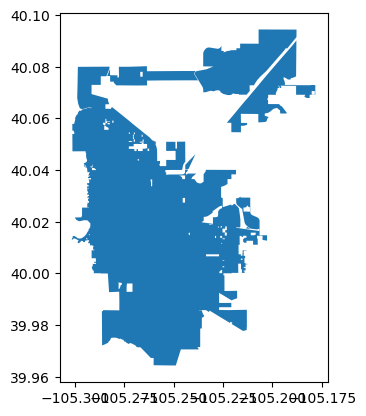

In [24]:
boulder_boundary = gpd.read_file(r"../Data/muni_boundaries/boulder.shp")
boulder_boundary.plot()

<Axes: >

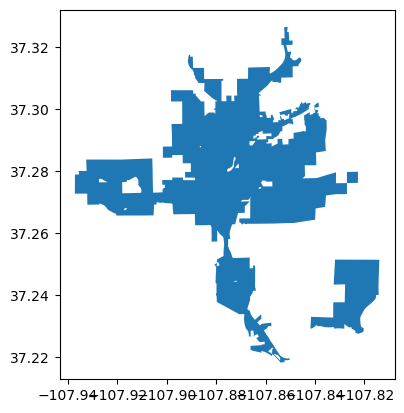

In [25]:
durango_boundary = gpd.read_file(r"../Data/muni_boundaries/durango.shp")
durango_boundary.plot()

<Axes: >

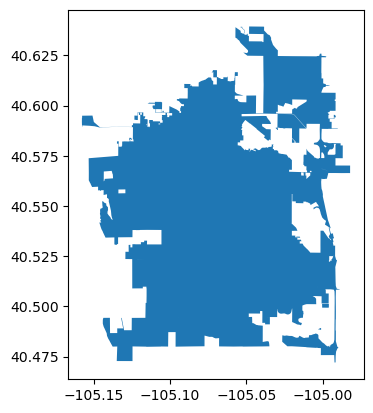

In [26]:
fort_collins_boundary = gpd.read_file(r"../Data/muni_boundaries/fort_collins.shp")
fort_collins_boundary.plot()

<Axes: >

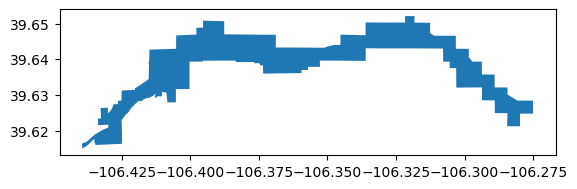

In [27]:
vail_boundary = gpd.read_file(r"../Data/muni_boundaries/vail.shp")
vail_boundary.plot()

<Axes: >

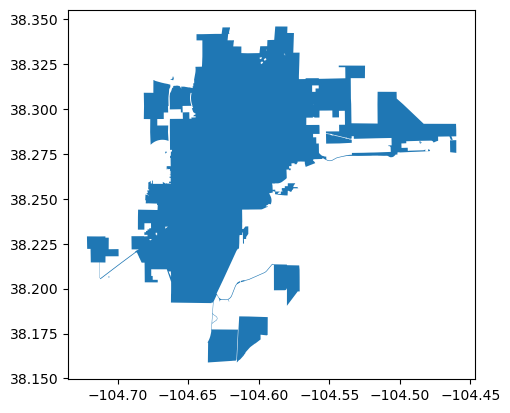

In [28]:
pueblo_boundary = gpd.read_file(r"../Data/muni_boundaries/pueblo.shp")
pueblo_boundary.plot()

<Axes: >

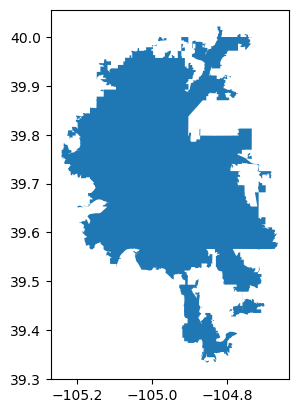

In [29]:
denver_boundary = gpd.read_file("../Data/muni_boundaries/denver_uza_akcicek.shp")
denver_boundary.plot()

### gathering data within the boundaries

In [30]:
#denver is particular to smart commute - don't want to cloud with people who visited denver from other places
all_sc_within_denver = trip_program_df_gdf[(trip_program_df_gdf.within(denver_boundary.geometry.iloc[0])) & (trip_program_df_gdf.program == "sc")]

In [31]:
all_within_boulder = trip_program_df_gdf[trip_program_df_gdf.within(boulder_boundary.geometry.iloc[0])]
all_within_durango = trip_program_df_gdf[trip_program_df_gdf.within(durango_boundary.geometry.iloc[0])]
all_within_fortcollins = trip_program_df_gdf[trip_program_df_gdf.within(fort_collins_boundary.geometry.iloc[0])]
all_within_vail = trip_program_df_gdf[trip_program_df_gdf.within(vail_boundary.geometry.iloc[0])]
all_within_pueblo = trip_program_df_gdf[trip_program_df_gdf.within(pueblo_boundary.geometry.iloc[0])]

### splitting out car trips and e-bike trips to compare

In [32]:
# car_like_trips

In [33]:
#denver
# car_like_start_or_end_within_denver = car_like_trips[(car_like_trips.within(denver_boundary.geometry.iloc[0])) & (car_like_trips.program == "sc")]
# e_bike_start_or_end_within_denver = e_bike_trips[(e_bike_trips.within(denver_boundary.geometry.iloc[0])) & (e_bike_trips.program == "sc")]

#boulder
car_like_start_or_end_within_boulder = car_like_trips[car_like_trips.within(boulder_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_boulder = e_bike_trips[e_bike_trips.within(boulder_boundary.geometry.iloc[0])]

#durango
car_like_start_or_end_within_durango = car_like_trips[car_like_trips.within(durango_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_durango = e_bike_trips[e_bike_trips.within(durango_boundary.geometry.iloc[0])]

#fort collins
car_like_start_or_end_within_fortcollins = car_like_trips[car_like_trips.within(fort_collins_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_fortcollins = e_bike_trips[e_bike_trips.within(fort_collins_boundary.geometry.iloc[0])]

#vail
car_like_start_or_end_within_vail = car_like_trips[car_like_trips.within(vail_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_vail = e_bike_trips[e_bike_trips.within(vail_boundary.geometry.iloc[0])]

#pueblo
car_like_start_or_end_within_pueblo = car_like_trips[car_like_trips.within(pueblo_boundary.geometry.iloc[0])]
e_bike_start_or_end_within_pueblo = e_bike_trips[e_bike_trips.within(pueblo_boundary.geometry.iloc[0])]

### bonus plots [all, e-bike, car]

<Axes: >

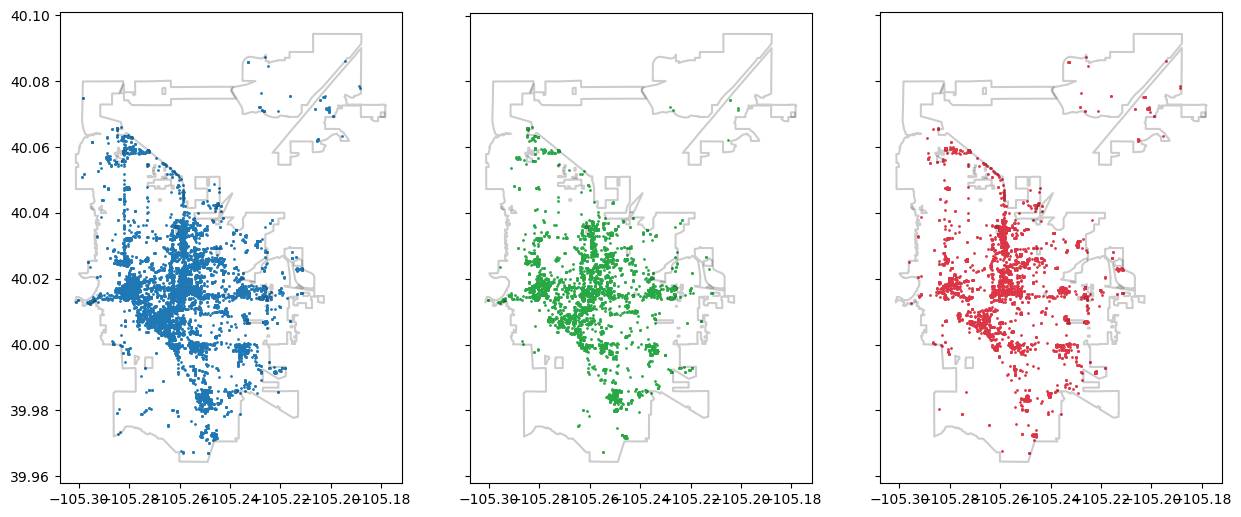

In [34]:
#boulder
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
boulder_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_boulder.plot(ax=ax_arr[0], markersize=1)
boulder_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_boulder.plot(color="#28a745", ax=ax_arr[1], markersize=1)
boulder_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_boulder.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<Axes: >

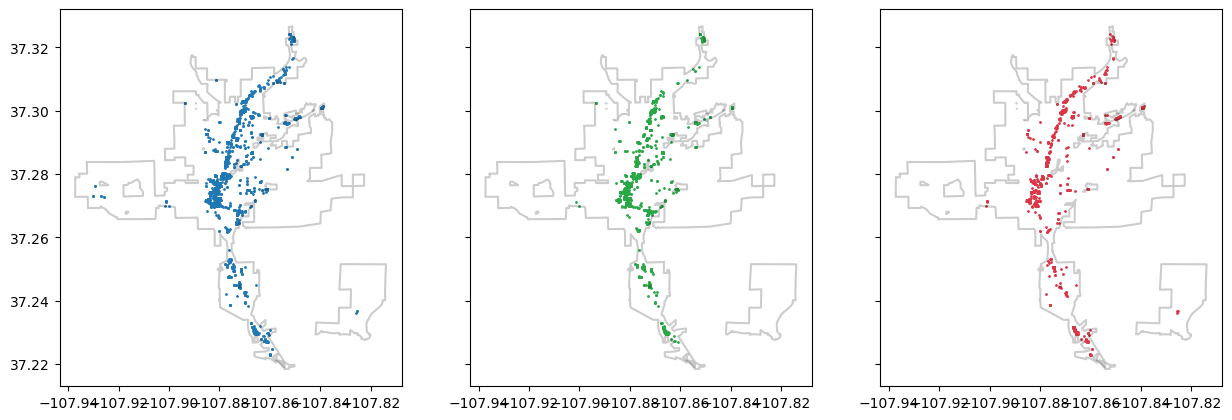

In [35]:
#durango
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
durango_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_durango.plot(ax=ax_arr[0], markersize=1)
durango_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_durango.plot(color="#28a745", ax=ax_arr[1], markersize=1)
durango_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_durango.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<Axes: >

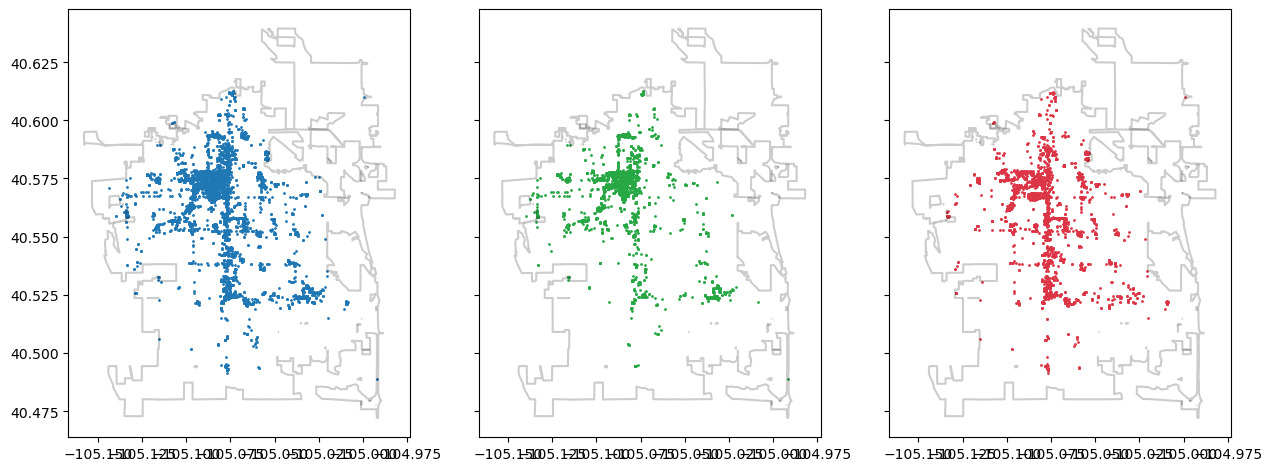

In [36]:
#fort collins
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
fort_collins_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_fortcollins.plot(ax=ax_arr[0], markersize=1)
fort_collins_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_fortcollins.plot(color="#28a745", ax=ax_arr[1], markersize=1)
fort_collins_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_fortcollins.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<Axes: >

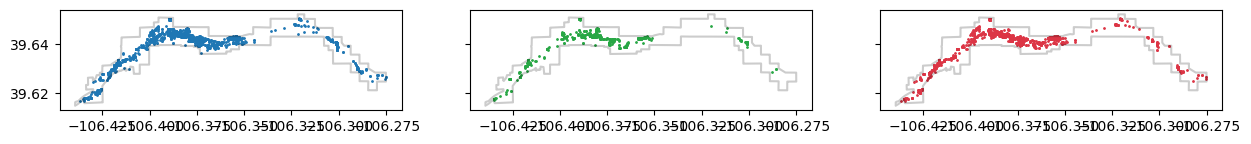

In [37]:
#vail
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
vail_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_vail.plot(ax=ax_arr[0], markersize=1)
vail_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_vail.plot(color="#28a745", ax=ax_arr[1], markersize=1)
vail_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_vail.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<Axes: >

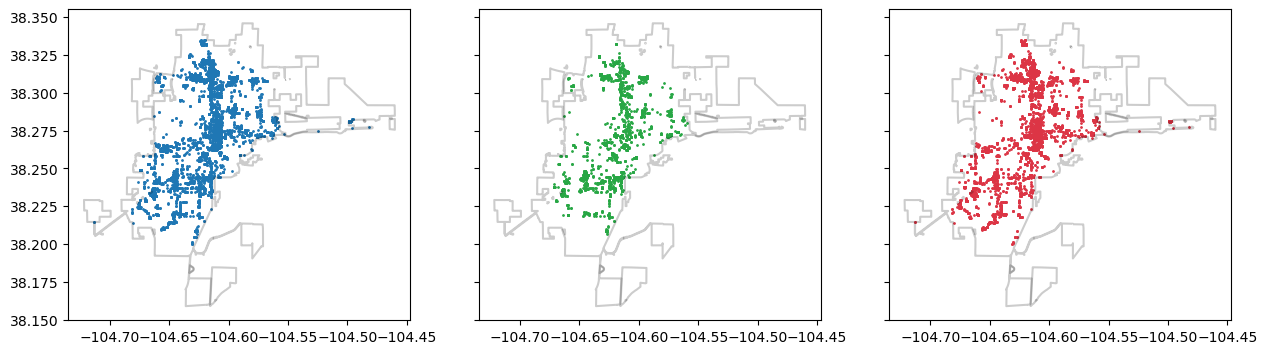

In [38]:
#pueblo
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
pueblo_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_within_pueblo.plot(ax=ax_arr[0], markersize=1)
pueblo_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within_pueblo.plot(color="#28a745", ax=ax_arr[1], markersize=1)
pueblo_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within_pueblo.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

<Axes: >

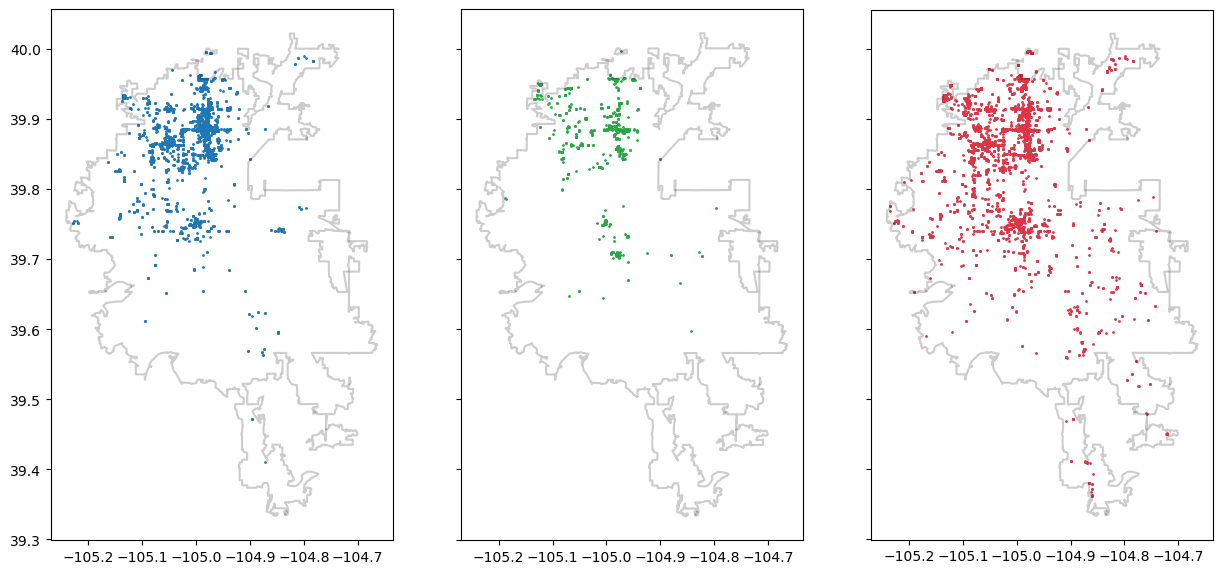

In [39]:
#denver
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(15,15), sharex=True, sharey=True)
denver_boundary.boundary.plot(ax=ax_arr[0], alpha = 0.2, color = "black", edgecolor='black')
all_sc_within_denver.plot(ax=ax_arr[0], markersize=1)
denver_boundary.boundary.plot(ax=ax_arr[1], alpha = 0.2, color = "black", edgecolor='black')
e_bike_start_or_end_within.plot(color="#28a745", ax=ax_arr[1], markersize=1)
denver_boundary.boundary.plot(ax=ax_arr[2], alpha = 0.2, color = "black", edgecolor='black')
car_like_start_or_end_within.plot(color="#dc3545", ax=ax_arr[2], markersize=1)

### Preparing for block/pixel analysis

In [40]:
#read in block files
denver_blocks = gpd.read_file(r"../Data/muni_boundaries/denver_blocks.shp")
boulder_blocks= gpd.read_file(r"../Data/muni_boundaries/boulder_blocks.shp")
fort_collins_blocks = gpd.read_file(r"../Data/muni_boundaries/fort_collins_blocks.shp")
vail_blocks = gpd.read_file(r"../Data/muni_boundaries/vail_blocks.shp")
durango_blocks = gpd.read_file(r"../Data/muni_boundaries/durango_blocks.shp")
pueblo_blocks = gpd.read_file(r"../Data/muni_boundaries/pueblo_blocks.shp")

In [41]:
#read in pixel files
denver_pixels = gpd.read_file(r"../Data/muni_boundaries/denver_pixels_ca.shp")
boulder_pixels= gpd.read_file(r"../Data/muni_boundaries/boulder_pixels.shp")
fort_collins_pixels = gpd.read_file(r"../Data/muni_boundaries/fortcollins_pixels.shp")
vail_pixels= gpd.read_file(r"../Data/muni_boundaries/vail_pixels.shp")
durango_pixels = gpd.read_file(r"../Data/muni_boundaries/durango_pixels.shp")
pueblo_pixels = gpd.read_file(r"../Data/muni_boundaries/pueblo_pixels.shp")

In [42]:
## set up the get counts -- note the "within place" used to pull from -- denver's only inclueds smart commute

#denver First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts(pixel_polygon):
    all_trip_count = np.count_nonzero(all_sc_within_denver.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# boulder First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_boulder(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_boulder.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_boulder.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_boulder.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# fort collins First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_fortcollins(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_fortcollins.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_fortcollins.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_fortcollins.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# vail First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_vail(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_vail.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_vail.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_vail.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# Durango First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_durango(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_durango.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_durango.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_durango.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

# pueblo First, let's just make a dataframe with the three different counts: total, e-bike, car-like, for each polygon
def get_counts_pueblo(pixel_polygon):
    all_trip_count = np.count_nonzero(all_within_pueblo.within(pixel_polygon))
    e_bike_trip_count = np.count_nonzero(e_bike_start_or_end_within_pueblo.within(pixel_polygon))
    car_like_trip_count = np.count_nonzero(car_like_start_or_end_within_pueblo.within(pixel_polygon))
    return pd.Series([all_trip_count, e_bike_trip_count, car_like_trip_count])

### data processing for e-bike : cars ratios [pixels and blocks]

In [43]:
#get the counts (blocks)
denver_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = denver_blocks.geometry.apply(lambda pp: get_counts(pp))
boulder_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = boulder_blocks.geometry.apply(lambda pp: get_counts_boulder(pp))
fort_collins_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = fort_collins_blocks.geometry.apply(lambda pp: get_counts_fortcollins(pp))
vail_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = vail_blocks.geometry.apply(lambda pp: get_counts_vail(pp))
durango_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = durango_blocks.geometry.apply(lambda pp: get_counts_durango(pp))
pueblo_blocks[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = pueblo_blocks.geometry.apply(lambda pp: get_counts_pueblo(pp))

In [44]:
#get the counts (pixels)
denver_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = denver_pixels.geometry.apply(lambda pp: get_counts(pp))
boulder_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = boulder_pixels.geometry.apply(lambda pp: get_counts_boulder(pp))
fort_collins_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = fort_collins_pixels.geometry.apply(lambda pp: get_counts_fortcollins(pp))
vail_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = vail_pixels.geometry.apply(lambda pp: get_counts_vail(pp))
durango_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = durango_pixels.geometry.apply(lambda pp: get_counts_durango(pp))
pueblo_pixels[["all_trip_count", "e_bike_trip_count", "car_like_trip_count"]] = pueblo_pixels.geometry.apply(lambda pp: get_counts_pueblo(pp))

In [45]:
#get ratio of bikes to cars (blocks)
denver_blocks["e_bike_2_car_like"] = denver_blocks.e_bike_trip_count / denver_blocks.car_like_trip_count
boulder_blocks["e_bike_2_car_like"] = boulder_blocks.e_bike_trip_count / boulder_blocks.car_like_trip_count
fort_collins_blocks["e_bike_2_car_like"] = fort_collins_blocks.e_bike_trip_count / fort_collins_blocks.car_like_trip_count
vail_blocks["e_bike_2_car_like"] = vail_blocks.e_bike_trip_count / vail_blocks.car_like_trip_count
durango_blocks["e_bike_2_car_like"] = durango_blocks.e_bike_trip_count / durango_blocks.car_like_trip_count
pueblo_blocks["e_bike_2_car_like"] = pueblo_blocks.e_bike_trip_count / pueblo_blocks.car_like_trip_count

In [46]:
#get ratio of bikes to cars (pixels)
denver_pixels["e_bike_2_car_like"] = denver_pixels.e_bike_trip_count / denver_pixels.car_like_trip_count
boulder_pixels["e_bike_2_car_like"] = boulder_pixels.e_bike_trip_count / boulder_pixels.car_like_trip_count
fort_collins_pixels["e_bike_2_car_like"] = fort_collins_pixels.e_bike_trip_count / fort_collins_pixels.car_like_trip_count
vail_pixels["e_bike_2_car_like"] = vail_pixels.e_bike_trip_count / vail_pixels.car_like_trip_count
durango_pixels["e_bike_2_car_like"] = durango_pixels.e_bike_trip_count / durango_pixels.car_like_trip_count
pueblo_pixels["e_bike_2_car_like"] = pueblo_pixels.e_bike_trip_count / pueblo_pixels.car_like_trip_count

In [47]:
#replacing infinity with max (blocks)
denver_blocks.replace(np.inf, denver_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
boulder_blocks.replace(np.inf, boulder_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
fort_collins_blocks.replace(np.inf, fort_collins_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
vail_blocks.replace(np.inf, vail_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
durango_blocks.replace(np.inf, durango_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
pueblo_blocks.replace(np.inf, pueblo_blocks.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)

In [48]:
#replacing infinity with max (blocks)
denver_pixels.replace(np.inf, denver_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
boulder_pixels.replace(np.inf, boulder_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
fort_collins_pixels.replace(np.inf, fort_collins_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
vail_pixels.replace(np.inf, vail_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
durango_pixels.replace(np.inf, durango_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)
pueblo_pixels.replace(np.inf, pueblo_pixels.replace(np.inf, 0).e_bike_2_car_like.max(), inplace=True)

In [49]:
#calculate where e-bike > car (blocks) -- put in T/F
denver_blocks["e_bike_better"] = pd.Categorical(denver_blocks.e_bike_2_car_like >= 1)
boulder_blocks["e_bike_better"] = pd.Categorical(boulder_blocks.e_bike_2_car_like >= 1)
fort_collins_blocks["e_bike_better"] = pd.Categorical(fort_collins_blocks.e_bike_2_car_like >= 1)
vail_blocks["e_bike_better"] = pd.Categorical(vail_blocks.e_bike_2_car_like >= 1)
durango_blocks["e_bike_better"] = pd.Categorical(durango_blocks.e_bike_2_car_like >= 1)
pueblo_blocks["e_bike_better"] = pd.Categorical(pueblo_blocks.e_bike_2_car_like >= 1)

In [50]:
#calculate where e-bike is > car (pixels) -- put in T/F
denver_pixels["e_bike_better"] = pd.Categorical(denver_pixels.e_bike_2_car_like >= 1)
boulder_pixels["e_bike_better"] = pd.Categorical(boulder_pixels.e_bike_2_car_like >= 1)
fort_collins_pixels["e_bike_better"] = pd.Categorical(fort_collins_pixels.e_bike_2_car_like >= 1)
vail_pixels["e_bike_better"] = pd.Categorical(vail_pixels.e_bike_2_car_like >= 1)
durango_pixels["e_bike_better"] = pd.Categorical(durango_pixels.e_bike_2_car_like >= 1)
pueblo_pixels["e_bike_better"] = pd.Categorical(pueblo_pixels.e_bike_2_car_like >= 1)

In [51]:
#remove nan ratios in blocks
denver_blocks_2 = denver_blocks[denver_blocks['e_bike_2_car_like'].notna()]
boulder_blocks_2 = boulder_blocks[boulder_blocks['e_bike_2_car_like'].notna()]
fort_collins_blocks_2 = fort_collins_blocks[fort_collins_blocks['e_bike_2_car_like'].notna()]
vail_blocks_2 = vail_blocks[vail_blocks['e_bike_2_car_like'].notna()]
durango_blocks_2 = durango_blocks[durango_blocks['e_bike_2_car_like'].notna()]
pueblo_blocks_2 = pueblo_blocks[pueblo_blocks['e_bike_2_car_like'].notna()]

In [52]:
#remove nan ratios in pixels
denver_pixels_2 = denver_pixels[denver_pixels['e_bike_2_car_like'].notna()]
boulder_pixels_2 = boulder_pixels[boulder_pixels['e_bike_2_car_like'].notna()]
fort_collins_pixels_2 = fort_collins_pixels[fort_collins_pixels['e_bike_2_car_like'].notna()]
vail_pixels_2 = vail_pixels[vail_pixels['e_bike_2_car_like'].notna()]
durango_pixels_2 = durango_pixels[durango_pixels['e_bike_2_car_like'].notna()]
pueblo_pixels_2 = pueblo_pixels[pueblo_pixels['e_bike_2_car_like'].notna()]

## Draw up the pixel plots

/tmp/ipykernel_319/748245077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denver_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)


<Axes: >

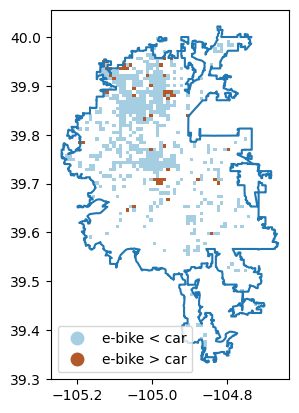

In [53]:
#denver (smart commute only!!)
ax = denver_boundary.boundary.plot()
denver_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)
denver_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

/tmp/ipykernel_319/889641816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boulder_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)


<Axes: >

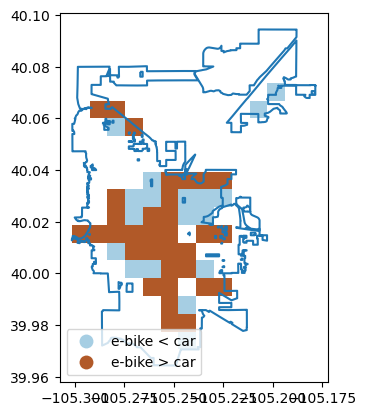

In [54]:
#boulder
ax = boulder_boundary.boundary.plot()
boulder_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)
boulder_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

/tmp/ipykernel_319/411610175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fort_collins_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)


<Axes: >

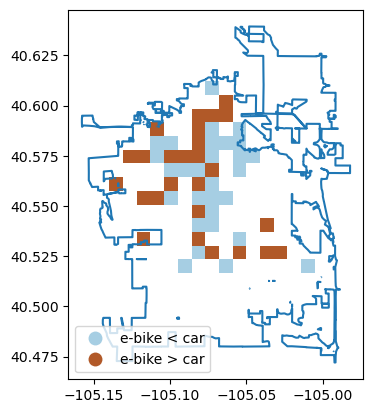

In [55]:
#fort collins
ax = fort_collins_boundary.boundary.plot()
fort_collins_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)
fort_collins_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

/tmp/ipykernel_319/916428835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vail_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)


<Axes: >

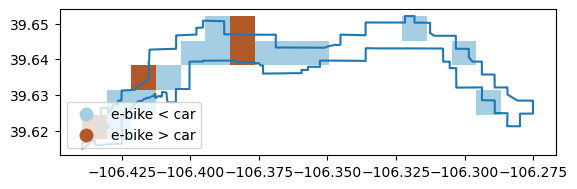

In [56]:
#vail
ax = vail_boundary.boundary.plot()
vail_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)
vail_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

/tmp/ipykernel_319/1153002758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  durango_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)


<Axes: >

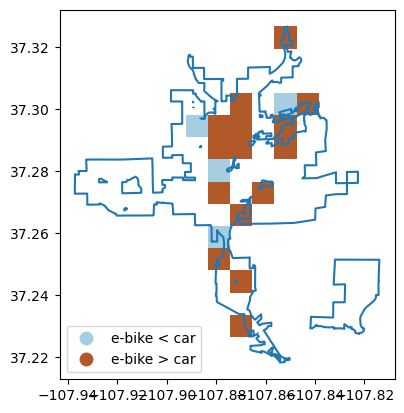

In [57]:
#durango
ax = durango_boundary.boundary.plot()
durango_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)
durango_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

/tmp/ipykernel_319/4269633272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pueblo_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)


<Axes: >

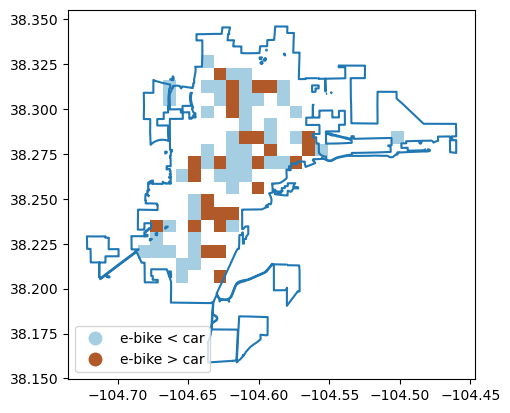

In [58]:
#pueblo
ax = pueblo_boundary.boundary.plot()
pueblo_pixels_2.replace({False: "e-bike < car", True: "e-bike > car"}, inplace=True)
pueblo_pixels_2.plot(column = "e_bike_better", ax = ax, legend=True, legend_kwds={"loc": "lower left"}, categorical=True, cmap="Paired", figsize=(12,6))

# Pixel Proportions

In [59]:
denver = denver_pixels_2.dropna().groupby("e_bike_better").count()
boulder = boulder_pixels_2.dropna().groupby("e_bike_better").count()
collins = fort_collins_pixels_2.dropna().groupby("e_bike_better").count()
durango = durango_pixels_2.dropna().groupby("e_bike_better").count()
vail = vail_pixels_2.dropna().groupby("e_bike_better").count()
pueblo = pueblo_pixels_2.dropna().groupby("e_bike_better").count()

In [60]:
denver['Smart Commute\n(Denver North)'] = denver['id'] / sum(denver['id'])
# denver['program'] = 'Smart Commute\n(Denver North)'
boulder['Comunity Cycles\n(Boulder)'] = boulder['id'] / sum(boulder['id'])
# boulder['program'] = 'Comunity Cycles\n(Boulder)'
collins['Fort Collins'] = collins['id'] / sum(collins['id'])
# collins['program'] = 'Fort Collins'
durango['Four Corners\n(Durango)'] = durango['id'] / sum(durango['id'])
# durango['program'] = 'Four Corners\n(Durango)'
vail['Vail'] = vail['id'] / sum(vail['id'])
# vail['program'] = 'Vail'
pueblo['Pueblo'] = pueblo['id'] / sum(pueblo['id'])
# pueblo['program'] = 'Pueblo'

pixels = pd.concat([denver, boulder, collins, durango, vail, pueblo], axis = 1)

pixels = pixels.drop(columns = ['id', 'geometry', 'left', 'top', 'right', 'bottom', 'all_trip_count', 'e_bike_trip_count', 'car_like_trip_count', 'e_bike_2_car_like'])

pixels = pixels.transpose()

#convert to %
pixels['e-bike < car'] = pixels['e-bike < car'] * 100
pixels['e-bike > car'] = pixels['e-bike > car'] * 100

pixels = pixels[['e-bike > car', 'e-bike < car']]

pixels

e_bike_better,e-bike > car,e-bike < car
Smart Commute\n(Denver North),7.949126,92.050874
Comunity Cycles\n(Boulder),64.705882,35.294118
Fort Collins,47.272727,52.727273
Four Corners\n(Durango),78.947368,21.052632
Vail,23.529412,76.470588
Pueblo,35.526316,64.473684


[Text(0, 0, 'Smart Commute\n(Denver North)'),
 Text(1, 0, 'Comunity Cycles\n(Boulder)'),
 Text(2, 0, 'Fort Collins'),
 Text(3, 0, 'Four Corners\n(Durango)'),
 Text(4, 0, 'Vail'),
 Text(5, 0, 'Pueblo')]

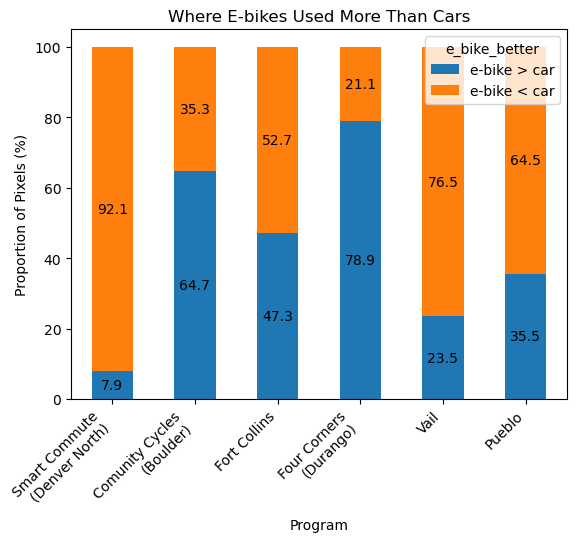

In [61]:
ax = pixels.plot.bar(stacked=True,
                            title="Where E-bikes Used More Than Cars", 
                            ylabel="Proportion of Pixels (%)",
                            xlabel = "Program",)
for c in ax.containers:
    labels = [f'{round(v.get_height(),1)}' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
    
ax.set_xticklabels(pixels.index, rotation=45, ha='right')